In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import subprocess
import sys

print(f"TensorFlow version = {tf.__version__}")
print(f"Python version = {sys.version}")

TensorFlow version = 2.19.0
Python version = 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Stroke types - must match the CSV filenames
GESTURES = ['drive', 'reves', 'smash', 'ruido']
NUM_GESTURES = len(GESTURES)

# Must match the Arduino sketch
SAMPLES_PER_GESTURE = 150
NUM_CHANNELS = 6  # aX, aY, aZ, gX, gY, gZ
INPUT_SIZE = SAMPLES_PER_GESTURE * NUM_CHANNELS  # 150 * 6 = 900

# Data directory
DATA_DIR = '/content/drive/MyDrive/Industria_4.0/'

# Training hyperparameters
EPOCHS = 400
BATCH_SIZE = 16
LEARNING_RATE = 0.001

# Data augmentation
AUGMENTATION_NOISE_STD = 0.02  # Standard deviation of Gaussian noise
AUGMENTATION_FACTOR = 2         # How many augmented copies per original sample

# Train/Test/Validation split ratios
TRAIN_RATIO = 0.6
TEST_RATIO = 0.2
# Validation = 1 - TRAIN_RATIO - TEST_RATIO = 0.2


In [3]:
# ============================================================
# 1. LOAD AND PREPARE DATA
# ============================================================
print("\n" + "=" * 60)
print("  PASO 1: CARGA Y PREPARACIÓN DE DATOS")
print("=" * 60)

ONE_HOT_ENCODED = np.eye(NUM_GESTURES)

inputs = []
outputs = []

for gesture_index, gesture in enumerate(GESTURES):
    filepath = os.path.join(DATA_DIR, f"{gesture}.csv")

    if not os.path.exists(filepath):
        print(f"  ⚠ ADVERTENCIA: No se encontró {filepath}. Saltando...")
        continue

    df = pd.read_csv(filepath)
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

    print(f"  {gesture:>8s}: {num_recordings} grabaciones ({df.shape[0]} muestras)")

    output = ONE_HOT_ENCODED[gesture_index]

    for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j
            # Normalize the input data between 0 and 1:
            # - Acceleration range: -4 to +4 G (BMI270 at ±4G)
            # - Gyroscope range: -2000 to +2000 deg/s (BMI270 at ±2000dps)
            tensor += [ #Data that is captured in Real Time should be transformed also that way
                (df['aX'][index] + 4) / 8,
                (df['aY'][index] + 4) / 8,
                (df['aZ'][index] + 4) / 8,
                (df['gX'][index] + 2000) / 4000,
                (df['gY'][index] + 2000) / 4000,
                (df['gZ'][index] + 2000) / 4000,
            ]
        inputs.append(tensor)
        outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print(f"\n  Total de muestras: {len(inputs)}")
print(f"  Forma de entrada: {inputs.shape}")
print(f"  Forma de salida:  {outputs.shape}")


  PASO 1: CARGA Y PREPARACIÓN DE DATOS
     drive: 101 grabaciones (15150 muestras)
     reves: 100 grabaciones (15000 muestras)
     smash: 100 grabaciones (15000 muestras)
     ruido: 30 grabaciones (4500 muestras)

  Total de muestras: 331
  Forma de entrada: (331, 900)
  Forma de salida:  (331, 4)


In [4]:
# ============================================================
# 2. DATA AUGMENTATION (Noise Injection)
# ============================================================
print("\n" + "=" * 60)
print("  PASO 2: AUMENTO DE DATOS")
print("=" * 60)

original_count = len(inputs)

augmented_inputs = []
augmented_outputs = []

for _ in range(AUGMENTATION_FACTOR):
    noise = np.random.normal(0, AUGMENTATION_NOISE_STD, inputs.shape)
    noisy_inputs = np.clip(inputs + noise, 0, 1)  # Keep in [0, 1] range
    augmented_inputs.append(noisy_inputs)
    augmented_outputs.append(outputs.copy())

# Combine original + augmented data
inputs = np.concatenate([inputs] + augmented_inputs, axis=0)
outputs = np.concatenate([outputs] + augmented_outputs, axis=0)

print(f"  Muestras originales: {original_count}")
print(f"  Muestras aumentadas: {len(inputs) - original_count}")
print(f"  Total tras aumento:  {len(inputs)}")


  PASO 2: AUMENTO DE DATOS
  Muestras originales: 331
  Muestras aumentadas: 662
  Total tras aumento:  993


In [5]:
# ============================================================
# 3. SHUFFLE AND SPLIT DATA
# ============================================================
print("\n" + "=" * 60)
print("  PASO 3: ALEATORIZACIÓN Y DIVISIÓN DE DATOS")
print("=" * 60)

num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(TRAIN_RATIO * num_inputs)
TEST_SPLIT = int(TEST_RATIO * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(f"  Entrenamiento:  {len(inputs_train)} muestras ({TRAIN_RATIO * 100:.0f}%)")
print(f"  Test:           {len(inputs_test)} muestras ({TEST_RATIO * 100:.0f}%)")
print(f"  Validación:     {len(inputs_validate)} muestras ({(1 - TRAIN_RATIO - TEST_RATIO) * 100:.0f}%)")



  PASO 3: ALEATORIZACIÓN Y DIVISIÓN DE DATOS
  Entrenamiento:  595 muestras (60%)
  Test:           198 muestras (20%)
  Validación:     200 muestras (20%)


In [6]:
# ============================================================
# 4. BUILD THE MODEL
# ============================================================
print("\n" + "=" * 60)
print("  PASO 4: CONSTRUCCIÓN DEL MODELO")
print("=" * 60)

# Improved architecture compared to the original:
# - More capacity (128 → 64 → 32 neurons) for 4-class problem
# - Dropout layers to prevent overfitting
# - Batch Normalization for training stability
# - Categorical Crossentropy (correct loss for multi-class classification)
# - Adam optimizer (better than RMSProp for this use case)

model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),

    # First hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Second hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Third hidden layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output layer - softmax for multi-class probability distribution
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',   # Correct loss for one-hot encoded labels
    metrics=['accuracy']               # Track accuracy instead of MAE
)

model.summary()



  PASO 4: CONSTRUCCIÓN DEL MODELO


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,564 (494.39 KB)

 Trainable params: 126,180 (492.89 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
# ============================================================
# 5. TRAIN THE MODEL
# ============================================================
print("\n" + "=" * 60)
print("  PASO 5: ENTRENAMIENTO DEL MODELO")
print("=" * 60)

# Callbacks for better training control
callbacks = [
    # Stop training when validation loss stops improving
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,           # Wait 50 epochs before stopping
        restore_best_weights=True,  # Keep the best model
        verbose=1
    ),
    # Reduce learning rate when validation loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,            # Halve the learning rate
        patience=20,           # Wait 20 epochs before reducing
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(inputs_validate, outputs_validate),
    callbacks=callbacks,
    verbose=1
)


  PASO 5: ENTRENAMIENTO DEL MODELO
Epoch 1/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5878 - loss: 1.0202 - val_accuracy: 0.6050 - val_loss: 1.3508 - learning_rate: 0.0010
Epoch 2/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9629 - loss: 0.1905 - val_accuracy: 0.6100 - val_loss: 0.9319 - learning_rate: 0.0010
Epoch 3/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9695 - loss: 0.1280 - val_accuracy: 0.9250 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 4/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9888 - loss: 0.0709 - val_accuracy: 0.9400 - val_loss: 0.5083 - learning_rate: 0.0010
Epoch 5/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0659 - val_accuracy: 0.8500 - val_loss: 0.5628 - learning_rate: 0.0010
Epoch 6/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9832 - loss: 0.0514 - val_accuracy: 0.7100 - val_loss: 0.6441 - learning_rate: 0.0010
Epoch 7/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu


  PASO 6: VISUALIZACIÓN DEL ENTRENAMIENTO


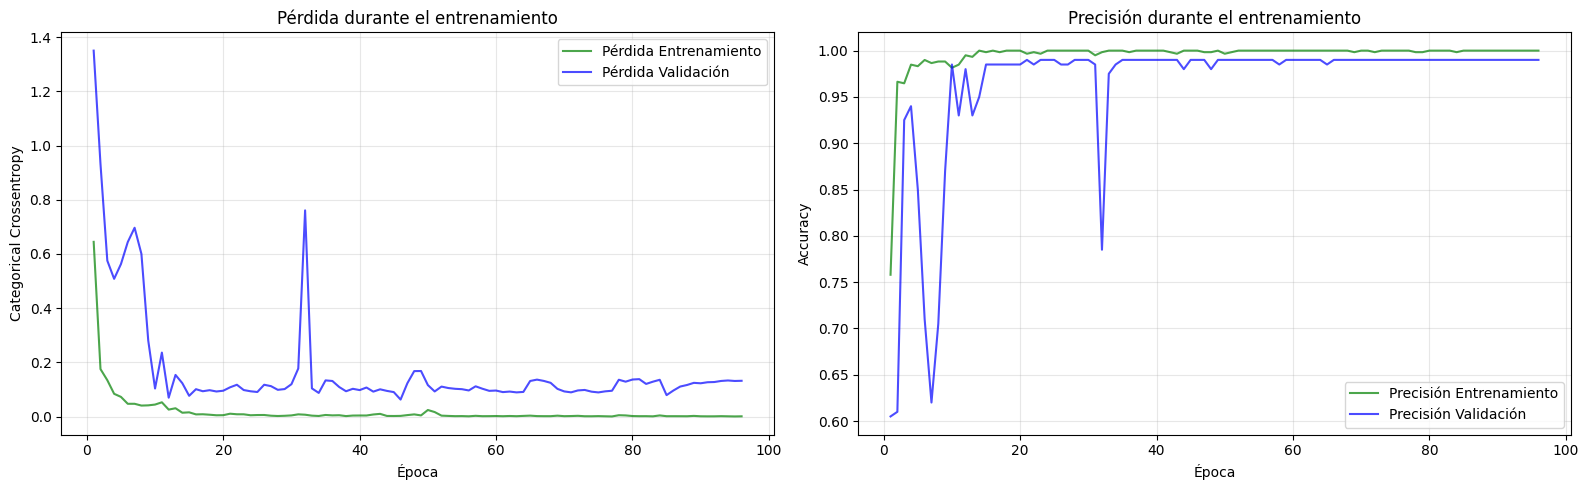

  Gráficas guardadas en training_history.png


In [8]:
# ============================================================
# 6. VISUALIZE TRAINING
# ============================================================
print("\n" + "=" * 60)
print("  PASO 6: VISUALIZACIÓN DEL ENTRENAMIENTO")
print("=" * 60)

plt.rcParams["figure.figsize"] = (16, 5)

fig, axes = plt.subplots(1, 2)

# Loss plot
epochs_range = range(1, len(history.history['loss']) + 1)
axes[0].plot(epochs_range, history.history['loss'], 'g-', label='Pérdida Entrenamiento', alpha=0.7)
axes[0].plot(epochs_range, history.history['val_loss'], 'b-', label='Pérdida Validación', alpha=0.7)
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Categorical Crossentropy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, history.history['accuracy'], 'g-', label='Precisión Entrenamiento', alpha=0.7)
axes[1].plot(epochs_range, history.history['val_accuracy'], 'b-', label='Precisión Validación', alpha=0.7)
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print("  Gráficas guardadas en training_history.png")



  PASO 7: EVALUACIÓN DEL MODELO

  Pérdida en test:    0.0312
  Precisión en test:  0.9949 (99.5%)

  Informe de clasificación:
              precision    recall  f1-score   support

       drive      0.986     1.000     0.993        71
       reves      1.000     1.000     1.000        49
       smash      1.000     0.983     0.991        59
       ruido      1.000     1.000     1.000        19

    accuracy                          0.995       198
   macro avg      0.997     0.996     0.996       198
weighted avg      0.995     0.995     0.995       198

  Matriz de confusión:
                drive    reves    smash    ruido
       drive       71        0        0        0
       reves        0       49        0        0
       smash        1        0       58        0
       ruido        0        0        0       19


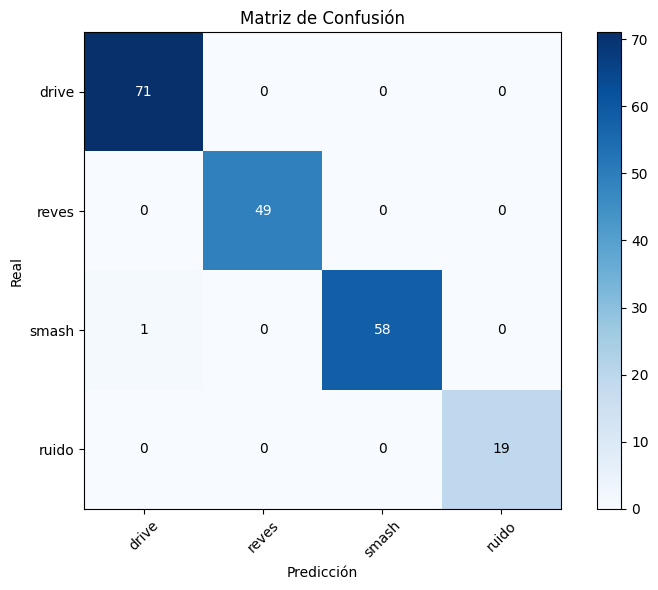

  Matriz guardada en confusion_matrix.png


In [9]:
# ============================================================
# 7. EVALUATE THE MODEL
# ============================================================
print("\n" + "=" * 60)
print("  PASO 7: EVALUACIÓN DEL MODELO")
print("=" * 60)

# Test set evaluation
test_loss, test_accuracy = model.evaluate(inputs_test, outputs_test, verbose=0)
print(f"\n  Pérdida en test:    {test_loss:.4f}")
print(f"  Precisión en test:  {test_accuracy:.4f} ({test_accuracy * 100:.1f}%)")

# Predictions and confusion matrix
predictions = model.predict(inputs_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(outputs_test, axis=1)

# Classification report
print("\n  Informe de clasificación:")
print(classification_report(actual_classes, predicted_classes,
                            target_names=GESTURES, digits=3))

# Confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
print("  Matriz de confusión:")
print(f"  {'':>10s}", end='')
for g in GESTURES:
    print(f" {g:>8s}", end='')
print()
for i, gesture in enumerate(GESTURES):
    print(f"  {gesture:>10s}", end='')
    for j in range(NUM_GESTURES):
        print(f" {cm[i][j]:>8d}", end='')
    print()

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_title('Matriz de Confusión')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
tick_marks = np.arange(NUM_GESTURES)
ax.set_xticks(tick_marks)
ax.set_xticklabels(GESTURES, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(GESTURES)

# Add text annotations
for i in range(NUM_GESTURES):
    for j in range(NUM_GESTURES):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.colorbar(im)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("  Matriz guardada en confusion_matrix.png")


In [10]:
# ============================================================
# 8. CONVERT TO TENSORFLOW LITE
# ============================================================
print("\n" + "=" * 60)
print("  PASO 8: CONVERSIÓN A TENSORFLOW LITE")
print("=" * 60)

# Standard conversion (float32)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_path = "gesture_model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

model_size = os.path.getsize(tflite_path)
print(f"  Modelo float32: {model_size:,} bytes ({model_size / 1024:.1f} KB)")

# INT8 quantized conversion (smaller, faster on microcontrollers)
converter_quant = tf.lite.TFLiteConverter.from_keras_model(model)
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]

# Use representative dataset for full integer quantization
def representative_dataset():
    for i in range(min(100, len(inputs_train))):
        yield [inputs_train[i:i+1].astype(np.float32)]

converter_quant.representative_dataset = representative_dataset

try:
    tflite_model_quant = converter_quant.convert()
    tflite_quant_path = "gesture_model_quant.tflite"
    with open(tflite_quant_path, "wb") as f:
        f.write(tflite_model_quant)

    quant_size = os.path.getsize(tflite_quant_path)
    print(f"  Modelo quantizado: {quant_size:,} bytes ({quant_size / 1024:.1f} KB)")
    print(f"  Reducción: {(1 - quant_size / model_size) * 100:.1f}%")
except Exception as e:
    print(f"  ⚠ Quantización falló: {e}")
    print("  Usando modelo float32.")
    tflite_quant_path = None


  PASO 8: CONVERSIÓN A TENSORFLOW LITE
Saved artifact at '/tmp/tmp_e85lxvz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 900), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136368042646736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042648848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042649424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042649040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042649808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042644432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042648080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042649616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042650768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136368042650960: TensorSpec(shape=(), dtype=tf.resou

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [11]:
# ============================================================
# 9. GENERATE ARDUINO HEADER FILE (model.h)
# ============================================================
print("\n" + "=" * 60)
print("  PASO 9: GENERACIÓN DEL ARCHIVO model.h")
print("=" * 60)

# Use the float32 model for maximum compatibility
model_to_convert = tflite_path

# Generate hex array using xxd
try:
    # Method 1: Using xxd
    with open("model.h", "w") as header_file:
        header_file.write("// Auto-generated TensorFlow Lite model for padel stroke classification\n")
        header_file.write(f"// Generated: {pd.Timestamp.now()}\n")
        header_file.write(f"// Gestures: {', '.join(GESTURES)}\n")
        header_file.write(f"// Samples per gesture: {SAMPLES_PER_GESTURE}\n")
        header_file.write(f"// Input size: {INPUT_SIZE}\n\n")
        header_file.write("#ifndef MODEL_H\n")
        header_file.write("#define MODEL_H\n\n")
        header_file.write("const unsigned char model[] = {\n")

    # Use xxd to convert binary to C array
    result = subprocess.run(
        f"cat {model_to_convert} | xxd -i >> model.h",
        shell=True, capture_output=True, text=True
    )

    if result.returncode == 0:
        with open("model.h", "a") as header_file:
            header_file.write("};\n\n")
            header_file.write(f"const unsigned int model_len = {os.path.getsize(model_to_convert)};\n\n")
            header_file.write("#endif // MODEL_H\n")
    else:
        # Fallback: generate hex array in Python
        print("  xxd no disponible, generando con Python...")
        with open(model_to_convert, "rb") as bin_file:
            model_bytes = bin_file.read()

        with open("model.h", "w") as header_file:
            header_file.write("// Auto-generated TensorFlow Lite model for padel stroke classification\n")
            header_file.write(f"// Generated: {pd.Timestamp.now()}\n")
            header_file.write(f"// Gestures: {', '.join(GESTURES)}\n\n")
            header_file.write("#ifndef MODEL_H\n")
            header_file.write("#define MODEL_H\n\n")
            header_file.write("const unsigned char model[] = {\n  ")

            for i, byte in enumerate(model_bytes):
                header_file.write(f"0x{byte:02x}")
                if i < len(model_bytes) - 1:
                    header_file.write(", ")
                if (i + 1) % 12 == 0:
                    header_file.write("\n  ")

            header_file.write("\n};\n\n")
            header_file.write(f"const unsigned int model_len = {len(model_bytes)};\n\n")
            header_file.write("#endif // MODEL_H\n")

    model_h_size = os.path.getsize("model.h")
    print(f"  Archivo model.h generado: {model_h_size:,} bytes")
    print(f"\n  Copia model.h a la carpeta del sketch Arduino IMU_Classifier_Padel.")

except Exception as e:
    print(f"  Error generando model.h: {e}")


  PASO 9: GENERACIÓN DEL ARCHIVO model.h
  Archivo model.h generado: 3,119,575 bytes

  Copia model.h a la carpeta del sketch Arduino IMU_Classifier_Padel.
